## Este codigo corresponde a usar PCA y luego regresion Logistica para las predicciones.

Importacion de librerias:

In [8]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [35]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
columns = ["tension"]

Visualizacion de medicion.

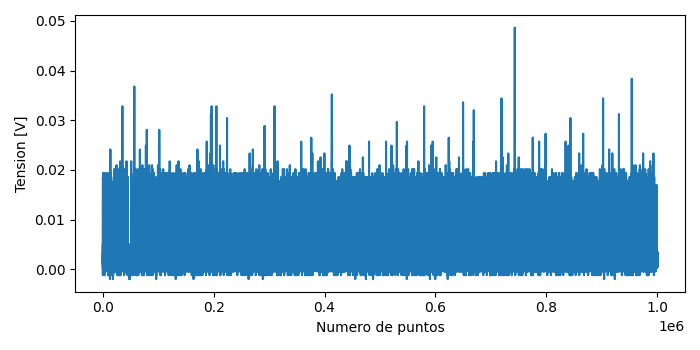

In [42]:
%matplotlib widget
dat = pd.read_csv("5.Wfm.csv", sep = ';')
dat.columns = columns
dat = -dat
plt.figure()
plt.plot(dat.tension)
plt.xlabel("Numero de puntos")
plt.ylabel("Tension [V]")
plt.show()  

Aca separo los pulsos y los guardo en el array VecPulses[], esto es simplemente poner un threshold que indica que hay un foton. Si no supero el threshold, avanzo un punto, si lo encuentro, avanzo 50 ns (50 puntos) que corresponde al tiempo de respuesta del MPPC y donde se supone que no deberia haber otro foton, salvo en el caso de AfterPulse.

1 Gsample/s -> 1 ns = 1 sample

In [11]:
num_puntos = 60
punto_final = 50 
threshold_1foton = 0.013

VecPulses = np.zeros((0,num_puntos))
Pulse = np.zeros(num_puntos)
k = 0
i = 100
while i< dat.size-500:
    if dat.tension[i] > threshold_1foton:
        k=k+1
        for j in range(num_puntos):
            Pulse[j] = dat.tension[i+j-(num_puntos-punto_final)]
        VecPulses = np.append(VecPulses, Pulse)
        VecPulses = VecPulses.reshape((k,num_puntos))
        i = i+punto_final
        
        continue
    else:
        i += 1
        continue

Codigo para visualizar los pulsos uno por uno.

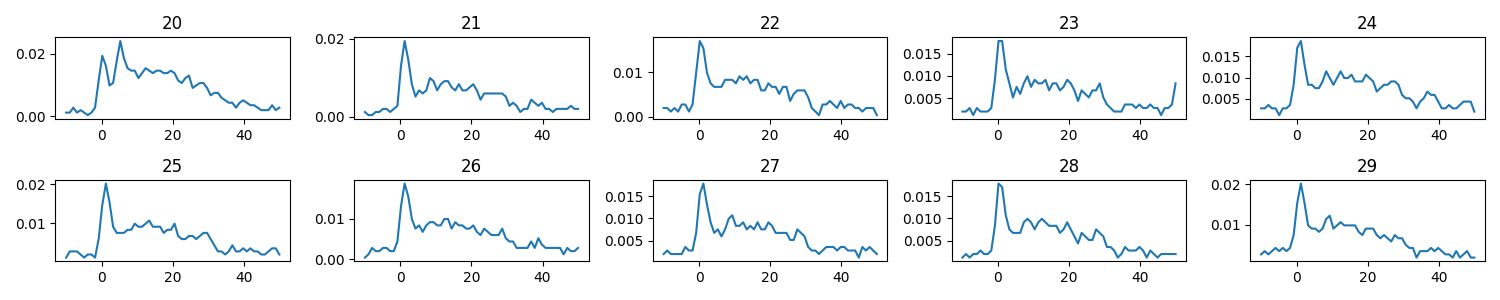

In [44]:
t = np.linspace(punto_final-num_puntos, punto_final, num_puntos)
m = 2
m = m-1
plt.close()
plt.figure(figsize=(15,3))
for l in range(10+m*10,20+m*10):
    plt.subplot(2,5, l+1-(10+m*10))
    plt.plot(t, VecPulses[l])
    plt.title(l)

Lo siguiente fue buscar a mano los pulsos para entrenamiento y guardarlos en csv.

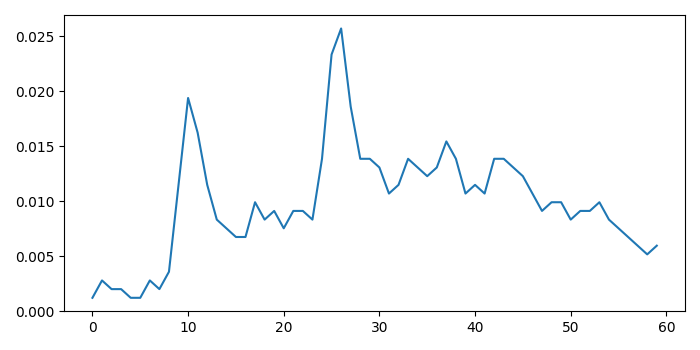

No such comm: 66d7f2155a864a6a8117b074453a367d


In [13]:
buffer = pd.read_csv("1_a.csv")
columns = ["time", "tension"]
buffer.columns = columns
plt.close()
plt.figure()
plt.plot(buffer.time, buffer.tension)
plt.show()

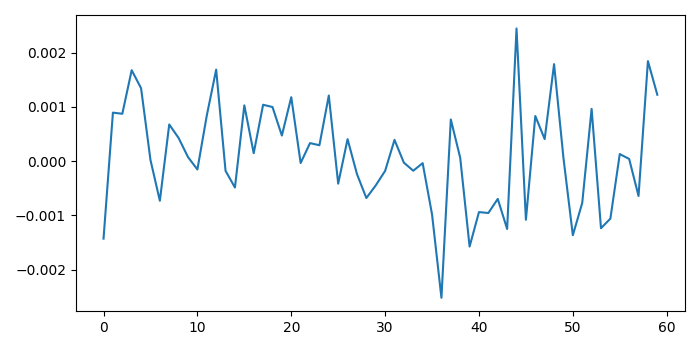

In [16]:
white_noise = np.random.normal(0, 0.001, num_puntos)
plt.close()
plt.figure()
plt.plot(white_noise)

Esta parte es de data augmentation. Debido a que es dificil encontrar datos a mano para entrenar la red, ya que son mas bien raros, me canse a los 35 de cada uno y decidi sumarles ruido para obtener un total de 350 pulsos de cada tipo para entrenar las redes.

In [17]:
datos_pulso = np.zeros((350, num_puntos))
datos_afterpulse = np.zeros((350, num_puntos))
datos_doble_pulso = np.zeros((350, num_puntos))
columns = ["time", "tension"]

for i in range(35):
    dat_p = pd.read_csv(str(i+1)+"_f.csv")
    dat_p.columns = columns
    datos_pulso[i] = dat_p.tension
    dat_a = pd.read_csv(str(i+1)+"_a.csv")
    dat_a.columns = columns
    datos_afterpulse[i] = dat_a.tension
    dat_d = pd.read_csv(str(i+1)+"_d.csv")
    dat_d.columns = columns
    datos_doble_pulso[i] = dat_d.tension

for i in range(35,350,1):
    white_noise = np.random.normal(0, 0.001, num_puntos)
    dat_p = pd.read_csv(str(i%35+1)+"_f.csv")
    dat_p.columns = columns
    datos_pulso[i] = dat_p.tension + white_noise
    dat_a = pd.read_csv(str(i%35+1)+"_a.csv")
    dat_a.columns = columns
    datos_afterpulse[i] = dat_a.tension+white_noise
    dat_d = pd.read_csv(str(i%35+1)+"_d.csv")
    dat_d.columns = columns
    datos_doble_pulso[i] = dat_d.tension+white_noise


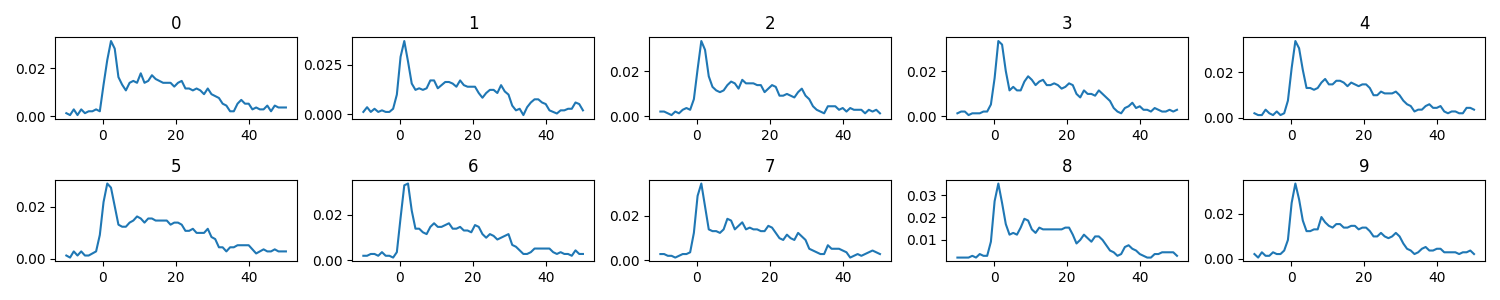

In [18]:
t = np.linspace(punto_final-num_puntos, punto_final, num_puntos)
m = 0
m = m-1
plt.close()
plt.figure(figsize=(15,3))
for l in range(10+m*10,20+m*10):
    plt.subplot(2,5, l+1-(10+m*10))
    plt.plot(t, datos_doble_pulso[l])
    plt.title(l)

Aca empieza el PCA. Use $n=2$ componentes. Se puede ver que para 2 componentes los 3 tipos de pulso estan bien diferenciados.

Varianza explicada por cada componente principal: [0.36556554 0.15849599]
Varianza total explicada: 0.5240615320959747


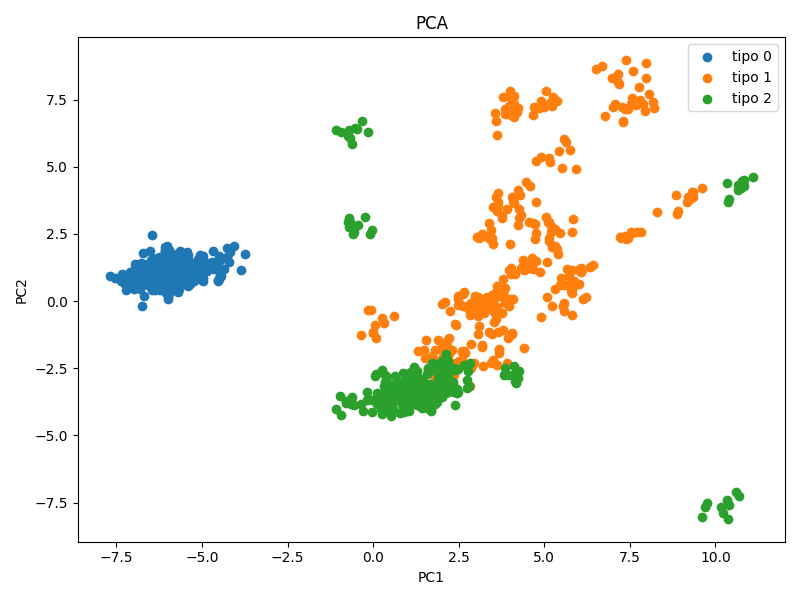

In [19]:
data = np.vstack((datos_pulso, datos_afterpulse, datos_doble_pulso))
labels_type1 = np.zeros((350, 1))
labels_type2 = np.ones((350, 1))
labels_type3 = np.full((350, 1), 2)
labels = np.vstack((labels_type1, labels_type2, labels_type3))

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

n_components = 2
pca = PCA(n_components=n_components)
data_pca = pca.fit_transform(data_scaled)

print(f'Varianza explicada por cada componente principal: {pca.explained_variance_ratio_}')
print(f'Varianza total explicada: {sum(pca.explained_variance_ratio_)}')
labels = labels.flatten()

plt.close()
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.scatter(data_pca[labels == i, 0], data_pca[labels == i, 1], label=f'tipo {i}')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA')
plt.legend()
plt.show()

In [20]:
from sklearn.model_selection import train_test_split

x_train_pca, x_test_pca, y_train, y_test = train_test_split(data_pca, labels, test_size=0.2, random_state=11)

Regresion logistica.

In [21]:
logistic_model = LogisticRegression(multi_class='ovr', max_iter=1000)
logistic_model.fit(x_train_pca, y_train)

y_pred = logistic_model.predict(x_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8904761904761904


Prueba y predicciones: 

In [22]:
double_count = 0
after_count = 0
after_pulsos = np.ndarray((100,60))
double_pulsos = np.ndarray((100,60))
for i in range(VecPulses.shape[0]):
    new_data_scaled = scaler.transform(VecPulses[i].reshape(1, -1))
    new_data_pca = pca.transform(new_data_scaled)
    new_prediction = logistic_model.predict(new_data_pca)
    if(new_prediction[0] == 1.0):
        after_pulsos[after_count] = VecPulses[i]
        after_count = after_count +1
        print("El pulso "+str(i) +" es un afterpulse.")
    if(new_prediction[0] == 2.0):
        print("El pulso "+str(i) + " es un doble foton.")
        double_pulsos[double_count] = VecPulses[i]
        double_count = double_count+1

El pulso 20 es un doble foton.
El pulso 44 es un afterpulse.
El pulso 49 es un doble foton.
El pulso 69 es un afterpulse.
El pulso 71 es un afterpulse.
El pulso 78 es un doble foton.
El pulso 89 es un afterpulse.
El pulso 106 es un doble foton.
El pulso 109 es un afterpulse.
El pulso 112 es un afterpulse.
El pulso 128 es un afterpulse.
El pulso 153 es un afterpulse.
El pulso 167 es un afterpulse.
El pulso 171 es un afterpulse.
El pulso 200 es un afterpulse.
El pulso 212 es un afterpulse.
El pulso 243 es un afterpulse.
El pulso 254 es un afterpulse.
El pulso 255 es un doble foton.
El pulso 257 es un doble foton.
El pulso 263 es un afterpulse.
El pulso 275 es un afterpulse.
El pulso 284 es un doble foton.
El pulso 304 es un doble foton.
El pulso 324 es un afterpulse.
El pulso 368 es un afterpulse.
El pulso 371 es un afterpulse.
El pulso 375 es un afterpulse.
El pulso 376 es un afterpulse.
El pulso 403 es un doble foton.
El pulso 428 es un doble foton.
El pulso 477 es un afterpulse.
El pu

In [23]:
print("Dobles: " + str(double_count)+"/"+str(VecPulses.shape[0]))
print("After: " + str(after_count)+"/"+str(VecPulses.shape[0]))

Dobles: 23/1282
After: 81/1282


Para visualizar los pulsos que predijo y tener una idea de si funciona mas o menos bien.

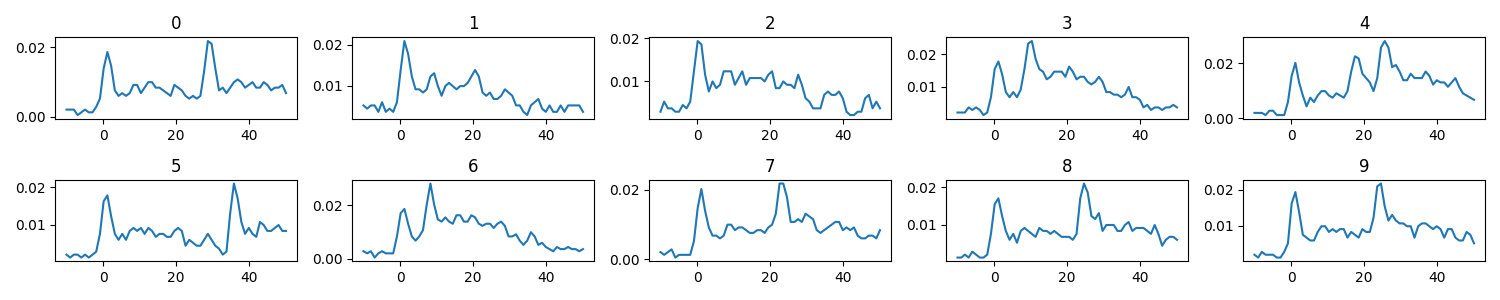

In [41]:
t = np.linspace(punto_final-num_puntos, punto_final, num_puntos)
m = 0
m = m-1
plt.close()
plt.figure(figsize=(15,3))
for l in range(10+m*10,20+m*10):
    plt.subplot(2,5, l+1-(10+m*10))
    plt.plot(t, after_pulsos[l])
    plt.title(l)

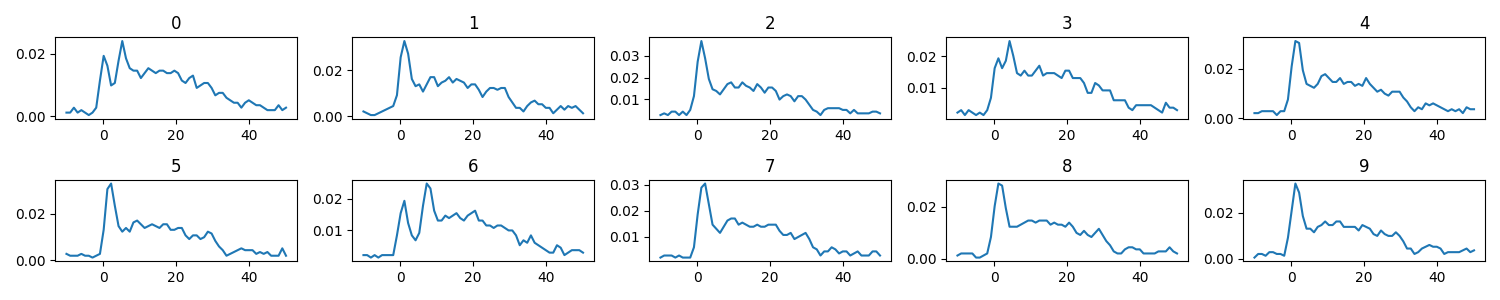

In [27]:
t = np.linspace(punto_final-num_puntos, punto_final, num_puntos)
m = 0
m = m-1
plt.close()
plt.figure(figsize=(15,3))
for l in range(10+m*10,20+m*10):
    plt.subplot(2,5, l+1-(10+m*10))
    plt.plot(t, double_pulsos[l])
    plt.title(l)

Como este modelo no funciona suuuuper bien, intente regularizar con L1 y L2, pero el resultado fue el mismo, supongo que porque el modelo es demasiado simple.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logistic_model_l2 = LogisticRegression(penalty='l2', multi_class='ovr', max_iter=1000, C=1.0)
logistic_model_l2.fit(x_train_pca, y_train)

y_pred_l2 = logistic_model_l2.predict(x_test_pca)

accuracy_l2 = accuracy_score(y_test, y_pred_l2)
print(f'Accuracy con L2: {accuracy_l2}')

Accuracy con L2: 0.8904761904761904


In [29]:
logistic_model_l1 = LogisticRegression(penalty='l1', solver='saga', multi_class='ovr', max_iter=1000, C=1.0)
logistic_model_l1.fit(x_train_pca, y_train)

y_pred_l1 = logistic_model_l1.predict(x_test_pca)

accuracy_l1 = accuracy_score(y_test, y_pred_l1)
print(f'Accuracy con L1: {accuracy_l1}')

Accuracy con L1: 0.8904761904761904


In [30]:
double_count = 0
after_count = 0
after_pulsos = np.ndarray((100,60))
double_pulsos = np.ndarray((100,60))
for i in range(VecPulses.shape[0]):
    new_data_scaled = scaler.transform(VecPulses[i].reshape(1, -1))
    new_data_pca = pca.transform(new_data_scaled)
    new_prediction = logistic_model_l2.predict(new_data_pca)
    if(new_prediction[0] == 1.0):
        after_pulsos[after_count] = VecPulses[i]
        after_count = after_count +1
        print("El pulso "+str(i) + " es un after")
    if(new_prediction[0] == 2.0):
        print("El pulso "+str(i) + " es un doble")
        double_pulsos[double_count] = VecPulses[i]
        double_count = double_count+1

El pulso 20 es un doble
El pulso 44 es un after
El pulso 49 es un doble
El pulso 69 es un after
El pulso 71 es un after
El pulso 78 es un doble
El pulso 89 es un after
El pulso 106 es un doble
El pulso 109 es un after
El pulso 112 es un after
El pulso 128 es un after
El pulso 153 es un after
El pulso 167 es un after
El pulso 171 es un after
El pulso 200 es un after
El pulso 212 es un after
El pulso 243 es un after
El pulso 254 es un after
El pulso 255 es un doble
El pulso 257 es un doble
El pulso 263 es un after
El pulso 275 es un after
El pulso 284 es un doble
El pulso 304 es un doble
El pulso 324 es un after
El pulso 368 es un after
El pulso 371 es un after
El pulso 375 es un after
El pulso 376 es un after
El pulso 403 es un doble
El pulso 428 es un doble
El pulso 477 es un after
El pulso 486 es un after
El pulso 509 es un after
El pulso 510 es un after
El pulso 518 es un after
El pulso 532 es un after
El pulso 538 es un after
El pulso 547 es un after
El pulso 560 es un doble
El puls